In [1]:
# Importing the required modules
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.2 MB/s 


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import warnings
import pickle
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/PW22RBA01 Capstone Project/Phase2/AP Data Analysis/With Indices/NDWI/Cleaned_Soil.csv')
# Importing the dataset
# df = pd.read_csv('Cleaned_Soil.csv')

Mounted at /content/drive


In [4]:
# Obtaining data specific to Anantapur

In [5]:
df = df[df['District'] == 'Krishna']
df.head()

,Unnamed: 0,Latitude,Longitude,District,Mandal,Village,SoilType,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,NDVI,ARVI,EVI,GCI,NDWI,Crop
1434,1434,16.71,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,8.04,0.29,0.49,12.14,98.0,4662.0,490.0,36.95,0.34,0.63,6.23,1.77,15.20,0.020030,0.015637,0.154926,0.062061,-0.030097,Cotton
1435,1435,16.70,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,7.98,0.56,0.40,25.06,222.0,3669.0,558.0,38.58,0.98,0.55,3.70,1.06,11.12,0.022201,0.017797,0.155367,0.069264,-0.033473,Chilli
1436,1436,16.71,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,8.08,0.42,0.43,10.05,160.0,5107.0,1453.0,21.19,0.51,1.19,10.85,2.37,22.73,0.020030,0.015637,0.154926,0.062061,-0.030097,Vegetables
1437,1437,16.71,80.55,Krishna,G Konduru,C.H.Madhavaram,Black,8.11,0.46,0.44,12.75,231.0,4812.0,1605.0,45.24,0.55,1.46,9.48,2.04,26.57,0.020030,0.015637,0.154926,0.062061,-0.030097,Vegetables
1438,1438,16.71,80.61,Krishna,G Konduru,Chevutur,Black,8.54,0.21,0.25,3.51,179.0,5183.0,1229.0,7.75,0.35,1.10,4.19,1.09,7.12,0.019861,0.015283,0.141737,0.064535,-0.031259,Cotton


In [6]:
# Dropping unnecessary columns
df = df.drop(['Unnamed: 0', 'Latitude', 'Longitude', 'District', 'Mandal', 'Village', 'ARVI', 'NDVI', 'GCI', 'NDWI'], axis = 1)
df.describe()

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,EVI
count,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000,266.000000
mean,7.877293,0.881992,0.599737,21.031053,211.180451,5135.481203,1432.281955,105.633797,1.124436,1.755677,34.976241,7.602293,22.065714,0.388319
std,0.523106,1.572241,0.209099,14.304957,154.542433,1528.346835,609.168496,147.923428,1.016811,0.642349,28.610180,4.824919,12.788403,0.480130
min,6.070000,0.110000,0.160000,1.360000,77.000000,635.000000,165.000000,4.450000,0.140000,0.540000,1.400000,0.030000,5.500000,-0.110782
25%,7.620000,0.370000,0.430000,11.580000,133.000000,4369.750000,967.750000,23.857500,0.542500,1.300000,8.815000,2.347500,12.822500,0.187233
50%,7.980000,0.530000,0.610000,16.725000,171.000000,5295.000000,1435.500000,50.270000,0.900000,1.735000,31.950000,8.070000,19.520000,0.308601
75%,8.210000,0.807500,0.740000,27.590000,231.750000,6240.750000,1813.000000,118.027500,1.317500,2.102500,49.512500,11.770000,26.840000,0.419478
max,9.090000,20.300000,1.150000,105.720000,1572.000000,9718.000000,3730.000000,995.940000,8.840000,3.750000,166.850000,19.470000,88.540000,4.543434


In [7]:
# Analysis of SoilType

In [8]:
df.SoilType.unique()

array(['Black', 'Red', 'BLACK'], dtype=object)

In [9]:
df['SoilType'] = df['SoilType'].replace(['Black', 'BLACK'], 'Black Soil')
df['SoilType'] = df['SoilType'].replace('Red', 'Red Soil')
df.SoilType.unique()

array(['Black Soil', 'Red Soil'], dtype=object)

In [10]:
soilCount = dict(df['SoilType'].value_counts())
soilCount

{'Black Soil': 250, 'Red Soil': 16}

<BarContainer object of 2 artists>

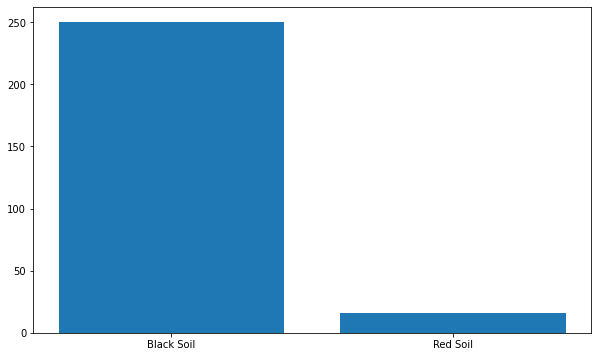

In [11]:
soilType = soilCount.keys()
soilCounts = soilCount.values()
plt.bar(soilType, soilCounts)

In [12]:
# Analysis of Crops grown 

In [13]:
df.Crop.unique()

array(['Cotton', 'Chilli', 'Vegetables', 'cotton', 'chill', 'Paddy',
       'Vegetable', 'Black gram', 'Maize', 'PULSE', 'MAZI', 'maize',
       'Mazi'], dtype=object)

In [14]:
df['Crop'].value_counts()

PULSE         80
Cotton        63
Black gram    52
Maize         31
Mazi           9
Vegetables     7
Paddy          7
Chilli         6
cotton         5
Vegetable      2
MAZI           2
maize          1
chill          1
Name: Crop, dtype: int64

Pulse        80
Cotton       68
BlackGram    52
Maize        43
Name: Crop, dtype: int64


<BarContainer object of 4 artists>

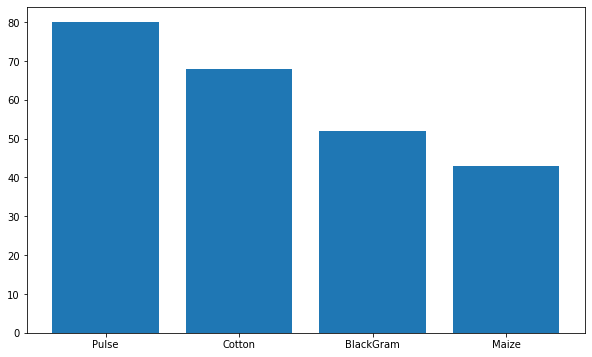

In [15]:
df['Crop'] = df['Crop'].replace('chill', 'Chilli')
df['Crop'] = df['Crop'].replace(['MAZI', 'maize', 'Mazi'], 'Maize')
df['Crop'] = df['Crop'].replace('cotton', 'Cotton')
df['Crop'] = df['Crop'].replace('Black gram', 'BlackGram')
df['Crop'] = df['Crop'].replace('PULSE', 'Pulse')
df = df[(df['Crop'] != 'Vegetable') & (df['Crop'] != 'Vegetables') & (df['Crop'] != 'Chilli') & (df['Crop'] != 'Paddy')]

print(df['Crop'].value_counts())
cropCount = dict(df['Crop'].value_counts())
cropType = cropCount.keys()
cropCounts = cropCount.values()
plt.bar(cropType, cropCounts)

In [16]:
# Getting rid of features that have a high correlation among one another

In [17]:
cor_matrix = df.corr()
cor_matrix

,pH,EC,OC,P,K,Ca,Mg,S,Zn,B,Fe,Cu,Mn,EVI
pH,1.000000,-0.194779,-0.397251,-0.345533,0.059415,-0.247552,-0.340166,-0.291813,-0.210989,-0.290784,-0.765760,-0.622046,-0.555247,-0.083885
EC,-0.194779,1.000000,0.224075,0.201661,0.273177,0.169868,0.226847,0.718952,0.072944,0.273555,0.027884,0.054795,0.087538,0.080182
OC,-0.397251,0.224075,1.000000,0.510703,0.251032,0.325660,0.292660,0.482694,0.490665,0.393414,0.545253,0.632245,0.325593,0.259459
P,-0.345533,0.201661,0.510703,1.000000,0.377933,0.005470,0.134836,0.294004,0.477350,0.353680,0.520016,0.341507,0.397529,0.130393
K,0.059415,0.273177,0.251032,0.377933,1.000000,-0.070437,-0.003110,0.328830,0.323908,0.146462,0.002124,-0.036796,0.117925,0.024632
Ca,-0.247552,0.169868,0.325660,0.005470,-0.070437,1.000000,0.805193,0.135697,0.072989,0.361858,0.327271,0.637827,0.320087,0.200007
Mg,-0.340166,0.226847,0.292660,0.134836,-0.003110,0.805193,1.000000,0.145356,0.077283,0.660054,0.426279,0.706528,0.448127,0.177747
S,-0.291813,0.718952,0.482694,0.294004,0.328830,0.135697,0.145356,1.000000,0.223393,0.299685,0.183475,0.172219,0.110838,0.215346
Zn,-0.210989,0.072944,0.490665,0.477350,0.323908,0.072989,0.077283,0.223393,1.000000,0.209275,0.427066,0.367775,0.268356,0.154485
B,-0.290784,0.273555,0.393414,0.353680,0.146462,0.361858,0.660054,0.299685,0.209275,1.000000,0.410415,0.567515,0.420113,0.157729


In [18]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
print('Columns to be dropped : ', to_drop)
df = df.drop(to_drop, axis = 1)
print('Columns taken into consideration : ', list(df.columns))

Columns to be dropped :  ['P', 'Mg', 'S', 'B', 'Fe', 'Cu', 'Mn']
Columns taken into consideration :  ['SoilType', 'pH', 'EC', 'OC', 'K', 'Ca', 'Zn', 'EVI', 'Crop']


In [19]:
# Separating the dependent and independent variables
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [20]:
# Encoding SoilType as it is a categorical variable
X = pd.get_dummies(X, prefix='', prefix_sep='')
print(X.head(1))
print(y.head(1))
X = X.values
y = y.values

        pH    EC    OC     K      Ca    Zn       EVI  Black Soil  Red Soil
1434  8.04  0.29  0.49  98.0  4662.0  0.34  0.154926           1         0
1434    Cotton
Name: Crop, dtype: object


In [21]:
# Standardizing the independent variables using Feature Scaling
sc1 = StandardScaler()
X[:, 0:6] = sc1.fit_transform(X[:, 0:6])

In [22]:
# Splitting the dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0, stratify=y)

# K-Nearest Neighbors Classifier

In [23]:
clf1 = KNeighborsClassifier(weights='distance')
clf1.fit(X_train, y_train)

KNeighborsClassifier(weights='distance')

In [24]:
y_test_pred = clf1.predict(X_test)
y_train_pred = clf1.predict(X_train)
AC1_train = accuracy_score(y_train, y_train_pred)
AC1_test = accuracy_score(y_test, y_test_pred)

In [25]:
print('Training Accuracy: ', AC1_train)
print('Testing Accuracy: ', AC1_test)

Training Accuracy:  1.0
Testing Accuracy:  0.6885245901639344


In [26]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf1, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 73.04 %
Standard Deviation: 7.22 %


# Decision Tree Classifier

In [27]:
clf2 = DecisionTreeClassifier(random_state=0)
clf2.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [28]:
y_test_pred = clf2.predict(X_test)
y_train_pred = clf2.predict(X_train)
AC2_train = accuracy_score(y_train, y_train_pred)
AC2_test = accuracy_score(y_test, y_test_pred)

In [29]:
print('Training Accuracy: ', AC2_train)
print('Testing Accuracy: ', AC2_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7704918032786885


In [30]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf2, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 69.85 %
Standard Deviation: 12.75 %


# Random Forest Classifier

In [31]:
clf3 = RandomForestClassifier(random_state=0)
clf3.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [32]:
y_test_pred = clf3.predict(X_test)
y_train_pred = clf3.predict(X_train)
AC3_train = accuracy_score(y_train, y_train_pred)
AC3_test = accuracy_score(y_test, y_test_pred)

In [33]:
print('Training Accuracy: ', AC3_train)
print('Testing Accuracy: ', AC3_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7377049180327869


In [34]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf3, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 76.49 %
Standard Deviation: 11.11 %


In [35]:
# pickle.dump(clf3, open('Krishna_model.pkl', 'wb'))
# pickle.dump(sc1, open('Krishna_scaler.pkl', 'wb'))

# XGBoost

In [36]:
clf4 = HistGradientBoostingClassifier(random_state=0)
clf4.fit(X_train, y_train)

HistGradientBoostingClassifier(random_state=0)

In [37]:
y_test_pred = clf4.predict(X_test)
y_train_pred = clf4.predict(X_train)
AC4_train = accuracy_score(y_train, y_train_pred)
AC4_test = accuracy_score(y_test, y_test_pred)

In [38]:
print('Training Accuracy: ', AC4_train)
print('Testing Accuracy: ', AC4_test)

Training Accuracy:  1.0
Testing Accuracy:  0.7377049180327869


In [39]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf4, X = X_train, y = y_train, cv = 10)

In [40]:
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 76.40 %
Standard Deviation: 7.59 %


# Multi-layer Perceptron Classifier

In [41]:
clf5 = MLPClassifier(random_state=0, learning_rate= 'adaptive')
clf5.fit(X_train, y_train)

MLPClassifier(learning_rate='adaptive', random_state=0)

In [42]:
y_test_pred = clf5.predict(X_test)
y_train_pred = clf5.predict(X_train)
AC5_train = accuracy_score(y_train, y_train_pred)
AC5_test = accuracy_score(y_test, y_test_pred)

In [43]:
print('Training Accuracy: ', AC5_train)
print('Testing Accuracy: ', AC5_test)

Training Accuracy:  0.8131868131868132
Testing Accuracy:  0.6885245901639344


In [44]:
# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = clf5, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

Accuracy: 71.46 %
Standard Deviation: 9.11 %


# Catboost

In [45]:
from catboost import CatBoostClassifier, Pool, cv

model = CatBoostClassifier(iterations=100, depth=2, learning_rate=1, loss_function='MultiClass', verbose=True)
model.fit(X_train, y_train)

model.calc_feature_statistics(X_train, y_train, feature=1, plot=True)

train_data = Pool(data=X_train, label=y_train)
model.get_feature_importance(train_data)

#Cross-Validation
cv_dataset = Pool(data=X_train, label=y_train)
params = {"iterations": 100, "depth": 2, "loss_function": "MultiClass", "verbose": False}
scores = cv(cv_dataset, params, fold_count=5, plot="True")

model = CatBoostClassifier(loss_function='MultiClass')
grid = {'learning_rate': [0.03, 0.1], 'depth': [4, 6, 10]}
grid_search_result = model.grid_search(grid, X=X_train, y=y_train, cv=3, plot=True)

model.score(X_test, y_test)

# k-Fold Cross Validation
accuracyList = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print('Accuracy: {:.2f} %'.format(accuracyList.mean() * 100))
print('Standard Deviation: {:.2f} %'.format(accuracyList.std() * 100))

0:	learn: 0.9155843	total: 46.7ms	remaining: 4.62s
1:	learn: 0.7981638	total: 47.1ms	remaining: 2.31s
2:	learn: 0.7119811	total: 47.5ms	remaining: 1.53s
3:	learn: 0.6417608	total: 47.9ms	remaining: 1.15s
4:	learn: 0.6032483	total: 48.2ms	remaining: 916ms
5:	learn: 0.5612655	total: 48.8ms	remaining: 765ms
6:	learn: 0.5045274	total: 49.6ms	remaining: 658ms
7:	learn: 0.4730657	total: 50.7ms	remaining: 583ms
8:	learn: 0.4486057	total: 51.2ms	remaining: 518ms
9:	learn: 0.4226286	total: 51.8ms	remaining: 466ms
10:	learn: 0.4133175	total: 52.3ms	remaining: 423ms
11:	learn: 0.4083730	total: 52.8ms	remaining: 387ms
12:	learn: 0.3800610	total: 53.3ms	remaining: 357ms
13:	learn: 0.3731022	total: 55.1ms	remaining: 339ms
14:	learn: 0.3558900	total: 55.7ms	remaining: 316ms
15:	learn: 0.3474124	total: 56.5ms	remaining: 296ms
16:	learn: 0.3401679	total: 57.3ms	remaining: 280ms
17:	learn: 0.3202580	total: 58ms	remaining: 264ms
18:	learn: 0.3171519	total: 59.1ms	remaining: 252ms
19:	learn: 0.3087841	tot

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.8033602034
bestIteration = 99

Training on fold [1/5]

bestTest = 0.8100095619
bestIteration = 99

Training on fold [2/5]

bestTest = 0.8434393913
bestIteration = 99

Training on fold [3/5]

bestTest = 0.8426204063
bestIteration = 99

Training on fold [4/5]

bestTest = 0.8449064632
bestIteration = 99



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
2:	learn: 1.2245756	total: 10.7ms	remaining: 3.56s
3:	learn: 1.1657700	total: 15.4ms	remaining: 3.83s
4:	learn: 1.1053922	total: 20.6ms	remaining: 4.1s
5:	learn: 1.0688709	total: 23.2ms	remaining: 3.84s
6:	learn: 1.0295688	total: 25.7ms	remaining: 3.65s
7:	learn: 0.9904082	total: 28.2ms	remaining: 3.5s
8:	learn: 0.9592115	total: 30.8ms	remaining: 3.39s
9:	learn: 0.9387807	total: 33.4ms	remaining: 3.31s
10:	learn: 0.9104895	total: 35.9ms	remaining: 3.23s
11:	learn: 0.8827259	total: 38.5ms	remaining: 3.17s
12:	learn: 0.8579057	total: 41ms	remaining: 3.11s
13:	learn: 0.8397577	total: 43.5ms	remaining: 3.06s
14:	learn: 0.8165848	total: 46ms	remaining: 3.02s
15:	learn: 0.7941158	total: 48.4ms	remaining: 2.98s
16:	learn: 0.7729404	total: 51ms	remaining: 2.95s
17:	learn: 0.7562064	total: 53.5ms	remaining: 2.92s
18:	learn: 0.7377986	total: 56.1ms	remaining: 2.9s
19:	learn: 0.7230344	total: 58.8ms	remaining: 2.88s
20:	learn: 0.7107135	total: 61